In [2]:
#Importing the libraries required for the Code
import tensorflow as tf
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input

from keras.layers import Dense
from keras import Model
from keras import optimizers

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
#fetching the cifar-10 from the inbuilt libraries.
(X_train,y_train),(X_test,y_test) = cifar10.load_data()

print("Shape of the training images:", X_train.shape)
print("Shape of the training labels:", y_train.shape)
print("Shape of the testing images:", X_test.shape)
print("Shape of the testing labels:", y_test.shape)

170498071/170498071 [==============================] - 13s 0us/step
Shape of the training images: (50000, 32, 32, 3)
Shape of the training labels: (50000, 1)
Shape of the testing images: (10000, 32, 32, 3)
Shape of the testing labels: (10000, 1)


In [5]:
#Labels for the cifar 10 dataset
cifar_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [6]:
import numpy as np

# Define the classes to extract
classes_to_extract = ['airplane', 'automobile', 'bird', 'cat', 'deer']

# Initialize lists to store the extracted images and labels
mini_cifar_images = []
mini_cifar_labels = []

# Initialize a counter to keep track of the number of images extracted for each class
class_image_count = {class_label: 0 for class_label in classes_to_extract}

# Iterate over the CIFAR-10 dataset
for image, label in zip(X_train, y_train):
    # Convert label from numeric to string class name
    class_name = cifar_classes[label[0]]

    # Check if the current image belongs to one of the classes to extract
    if class_name in classes_to_extract:
        # Check if the maximum number of images has been extracted for the current class
        if class_image_count[class_name] < 2000:
            # Append the image and its label to the mini dataset
            mini_cifar_images.append(image)
            mini_cifar_labels.append(class_name)

            # Increment the image count for the current class
            class_image_count[class_name] += 1

    # Check if the maximum number of images has been extracted for all classes
    if all(count >= 2000 for count in class_image_count.values()):
        break

# Convert the lists to NumPy arrays
mini_cifar_images = np.array(mini_cifar_images)
mini_cifar_labels = np.array(mini_cifar_labels)

# Print the shapes of the extracted dataset
print("Shape of mini CIFAR images:", mini_cifar_images.shape)
print("Shape of mini CIFAR labels:", mini_cifar_labels.shape)

Shape of mini CIFAR images: (10000, 32, 32, 3)
Shape of mini CIFAR labels: (10000,)


Selective Search is a region proposal algorithm used in object detection. It is designed to be fast with a very high recall. It is based on computing hierarchical grouping of similar regions based on color, texture, size and shape compatibility.

In [7]:
#Implementing the Selective search based regional proposal algorithm.

cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

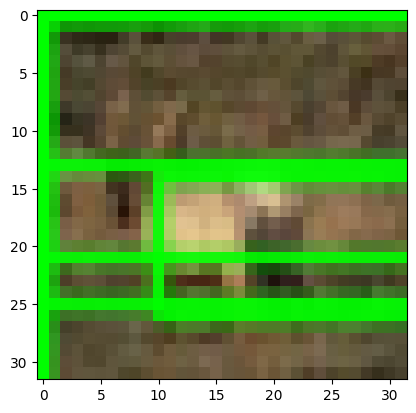

In [8]:
im = mini_cifar_images[0]
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in enumerate(rects):
  x, y, w, h = rect
  # print(x,y,w,h)
  # imOut = imOut[x:x+w,y:y+h]
  cv2.rectangle(imOut,(x,y),(x+w,y+h),(0,255,0),1,cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

Intersection over union Intersection over Union is simply an evaluation metric. Any algorithm that provides predicted bounding boxes as output can be evaluated using IoU.
More formally, in order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:
1.The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).
2.The predicted bounding boxes from our model.After getting these two we can find there intersection and union area,whih ultimately gives us our IoU.

In [9]:
def get_iou(bb1, bb2):
  # assuring for the proper dimension.
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']
  assert bb2['x1'] < bb2['x2']
  assert bb2['y1'] < bb2['y2']

  # calculating dimension of common area between these two boxes.
  x_left = max(bb1['x1'] ,bb1['x1'])
  y_top = max(bb1['y1'] ,bb1['y1'])
  x_right = min(bb1['x2'] ,bb1['x2'])
  y_bottom = min(bb1['y2'] ,bb1['y2'])

  # if there is no overlap output 0 as intersection area is zero
  if x_right < x_left or y_bottom < y_top:
    return 0.0

  # calculating intersection area.
  intersection_area = (x_right - x_left)*(y_bottom - y_top)
  # individual areas of both these bounding boxes.
  bb1_area = (bb1['x2'] - bb1['x1'])*(bb1['y2']-bb1['y1'])
  bb2_area = (bb2['x2'] - bb2['x1'])*(bb2['y2']-bb2['y1'])
  # union area = area of bb1 + area of bb2 - intersection of bb1 and bb2
  iou = intersection_area/float(bb1_area+bb2_area-intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou

Training data here is prepared according to following scheme:-
a) Those boxes which have an IoU greater than 0.7 (original paper it's 0.5) are considered as a positive example.
b) And boxes with relative low IoU 0.3 are taken to be negative examples.
Number of regions taken here is 30 positive and 30 negative (original paper have 32 and 96 respectively) of size 224x224. Note- Original paper also talk about warping but as we have resized them already so there is no need of it

In [10]:
#At the end of below code we will have our train data in these lists.
train_images = mini_cifar_images
train_labels = mini_cifar_labels

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

for img, label in zip(train_images, train_labels):
    try:
        if label == 0:  # Assuming 0 represents 'airplane' class
            gtvalues = [{"x1": 0, "y1": 0, "x2": 32, "y2": 32}]  # Assuming whole image as ground truth bbox
            ss.setBaseImage(img)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = img.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0

            for e, result in enumerate(ssresults):
                if e < 2000 and flag == 0:  # Until 2000 to get top 2000 regions only
                    for gtval in gtvalues:
                        x, y, w, h = result
                        iou = get_iou(gtval, {"x1": x, "x2": x + w, "y1": y, "y2": y + h})  # Calculating IoU
                        if counter < 30:  # Getting only 30 positive examples
                            if iou > 0.70:  # IoU or being positive is 0.7
                                train_images.append(imout[x:x + w, y:y + h])
                                train_labels.append(1)
                                counter += 1
                        else:
                            fflag = 1  # To ensure we have collected all positive examples
                        if falsecounter < 30:  # 30 negative examples are allowed only
                            if iou < 0.3:  # IoU or being negative is 0.3
                                train_images.append(imout[x:x + w, y:y + h])
                                train_labels.append(0)
                                falsecounter += 1
                        else:
                            bflag = 1  # To ensure we have collected all negative examples
                    if fflag == 1 and bflag == 1:
                        flag = 1  # To signal the completion of data extraction from a particular image
    except Exception as e:
        print(e)
        print("Error in processing an image.")
        continue

In [11]:
print(len(train_images))

10000


In [12]:
# conversion of train data into arrays for further training
X_new = np.array(train_images)
Y_new = np.array(train_labels)



In [13]:
class_to_index = {cls: i for i, cls in enumerate(classes_to_extract)}
Y_new = np.array([class_to_index[label] for label in Y_new])


In [14]:
from keras.layers import Input, UpSampling2D, Conv2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, MaxPooling2D, Flatten, Dropout, concatenate
from keras.models import Model,Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from keras.optimizers import Adam


In [15]:
vgg16_model = VGG16(weights='imagenet', include_top=False, classes=10, input_shape=(32,32,3))
# Defining the sequential model and adding the layers from VGG16 to it.
model_vgg = Sequential()

for layer in vgg16_model.layers:
    layer.trainable = False
    model_vgg.add(layer)

# Adding the top layers for the vgg16 for the mini cifar10.

model_vgg.add(Flatten())
model_vgg.add(Dense(512, activation='relu', name = 'hidden_layer1'))
model_vgg.add(Dropout(0.4))
model_vgg.add(Dense(256, activation='relu', name = 'hidden_layer2'))
model_vgg.add(Dropout(0.4))
model_vgg.add(Dense(5, activation='softmax', name = 'predictions'))

model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)         2

In [16]:
optimizer = Adam(learning_rate=0.01)
model_vgg.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [17]:
history_vgg = model_vgg.fit(X_new, Y_new, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
125/125 [==============================] - 8s 23ms/step - loss: 3.3749 - accuracy: 0.4211 - val_loss: 1.1104 - val_accuracy: 0.5580
Epoch 2/10
125/125 [==============================] - 2s 12ms/step - loss: 1.3305 - accuracy: 0.4876 - val_loss: 1.1387 - val_accuracy: 0.5235
Epoch 3/10
125/125 [==============================] - 2s 16ms/step - loss: 1.2936 - accuracy: 0.5089 - val_loss: 1.2017 - val_accuracy: 0.4775
Epoch 4/10
125/125 [==============================] - 2s 19ms/step - loss: 1.2778 - accuracy: 0.5054 - val_loss: 1.1202 - val_accuracy: 0.5680
Epoch 5/10
125/125 [==============================] - 2s 13ms/step - loss: 1.2796 - accuracy: 0.4981 - val_loss: 1.1102 - val_accuracy: 0.5610
Epoch 6/10
125/125 [==============================] - 2s 12ms/step - loss: 1.3236 - accuracy: 0.4865 - val_loss: 1.2318 - val_accuracy: 0.4985
Epoch 7/10
125/125 [==============================] - 2s 12ms/step - loss: 1.3606 - accuracy: 0.4650 - val_loss: 1.2258 - val_accuracy: 0.4760

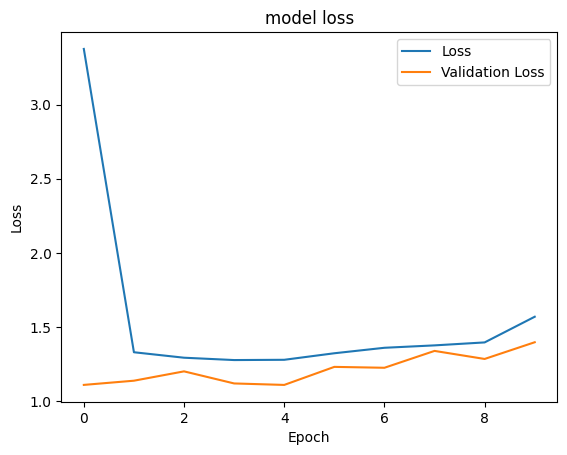

<Figure size 640x480 with 0 Axes>

In [18]:
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [35]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    directory="OxfordIIITPet",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)
validation_generator = train_datagen.flow_from_directory(
    directory="OxfordIIITPet",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dense(120, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.fit(train_generator, validation_data=validation_generator, epochs=30)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        